In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 200)

from card import Card
from board import Board
from player import Player
from rule import Rule
import optimal_strategy as opt

import multiprocessing
import time
from multiprocessing.pool import ThreadPool
import threading
from tqdm import notebook
notebook.tqdm.pandas()

from euchre_lib import *
from search_lib import *

In [28]:
notebook.tqdm.get_lock().locks = []

# Basic data exploration

In [3]:
board = Board()

In [15]:
df = pd.read_csv('stored_runs/1000_hands_000.csv')
df.head()

,p0c1,p0c1isD,p0c1isH,p0c1isS,p0c2,p0c2isD,p0c2isH,p0c2isS,p0c3,p0c3isD,p0c3isH,p0c3isS,p0c4,p0c4isD,p0c4isH,p0c4isS,p0c5,p0c5isD,p0c5isH,p0c5isS,p1c1,p1c1isD,p1c1isH,p1c1isS,p1c2,p1c2isD,p1c2isH,p1c2isS,p1c3,p1c3isD,p1c3isH,p1c3isS,p1c4,p1c4isD,p1c4isH,p1c4isS,p1c5,p1c5isD,p1c5isH,p1c5isS,p2c1,p2c1isD,p2c1isH,p2c1isS,p2c2,p2c2isD,p2c2isH,p2c2isS,p2c3,p2c3isD,p2c3isH,p2c3isS,p2c4,p2c4isD,p2c4isH,p2c4isS,p2c5,p2c5isD,p2c5isH,p2c5isS,p3c1,p3c1isD,p3c1isH,p3c1isS,p3c2,p3c2isD,p3c2isH,p3c2isS,p3c3,p3c3isD,p3c3isH,p3c3isS,p3c4,p3c4isD,p3c4isH,p3c4isS,p3c5,p3c5isD,p3c5isH,p3c5isS,TC_power,TC_isD,TC_isH,TC_isS,trump_isD,trump_isH,trump_isS,caller,round,alone,winner1,winner2,winner3,winner4,winner5,points02,points13,played1,played2,played3,played4,played5,played6,played7,played8,played9,played10,played11,played12,played13,played14,played15,played16,played17,played18,played19,played20,result,p0trueid,p1trueid,p2trueid,p3trueid
0,12,1,0,0,10,0,0,0,10,0,1,0,5,0,1,0,4,0,0,1,25,1,0,0,5,0,0,0,1,0,0,0,2,0,1,0,3,0,0,1,35,1,0,0,31,0,1,0,15,1,0,0,2,0,0,0,10,0,0,1,30,1,0,0,4,0,0,0,3,0,0,0,4,0,1,0,1,0,1,0,20,1,0,0,1,0,0,1,1,0,3,3,1,1,3,0,2,KC0,TC1,JC2,AC3,AH3,TH0,AS1,9H2,KH3,KD0,JH1,QH2,JD1,AD2,9D3,9C0,TD1,QC2,QD3,JS0,Sweep,1,2,3,0
1,20,1,0,0,2,0,0,0,1,0,0,0,4,0,1,0,1,0,1,0,12,1,0,0,4,0,0,0,10,0,0,1,5,0,0,1,2,0,0,1,35,1,0,0,30,1,0,0,5,0,1,0,2,0,1,0,3,0,0,1,31,0,1,0,25,1,0,0,10,0,0,0,10,0,1,0,4,0,0,1,15,1,0,0,1,0,0,3,1,0,3,3,0,0,2,2,0,AC0,9C1,QC2,TD3,JD3,KD0,QD1,9D2,KH3,AH0,9H1,TS2,JH0,TC1,KS2,AD3,QS0,QH1,AS2,TH3,EUCHRE,2,3,0,1
2,3,0,0,1,2,0,0,0,31,1,0,0,2,1,0,0,20,0,1,0,5,1,0,0,30,0,1,0,25,0,1,0,12,0,1,0,4,0,0,1,5,0,0,0,4,0,0,0,10,1,0,0,10,0,0,1,2,0,0,1,10,0,0,0,4,1,0,0,1,1,0,0,5,0,0,1,1,0,0,1,12,0,0,0,0,1,0,0,2,0,1,1,0,3,0,0,2,KD0,AD1,9D2,TD3,AS1,9S2,JS3,QS0,KC1,AC2,TC3,9H0,AH0,TS1,QD2,JD3,QH3,KH0,QC1,KS2,EUCHRE,3,0,1,2
3,15,0,0,1,5,0,0,0,1,0,0,0,5,1,0,0,1,0,1,0,12,0,0,1,4,0,0,0,10,1,0,0,4,1,0,0,2,0,1,0,31,0,0,0,30,0,0,1,10,0,0,0,10,0,1,0,3,0,1,0,25,0,0,1,2,0,0,0,3,1,0,0,2,1,0,0,4,0,1,0,20,0,0,1,0,0,1,3,1,0,3,3,3,3,3,0,2,QH0,9H1,TH2,AH3,JC3,KS0,TS1,9S2,JH3,TC0,9C1,QC2,AS3,TD0,KC1,QD2,QS3,JD0,KD1,AD2,Sweep,0,1,2,3
4,1,0,0,1,4,0,0,0,2,1,0,0,30,0,1,0,12,0,1,0,10,0,0,1,2,0,0,0,1,0,0,0,1,1,0,0,20,0,1,0,3,0,0,0,10,0,0,0,31,1,0,0,35,0,1,0,15,0,1,0,5,0,0,1,2,0,0,1,5,0,0,0,10,1,0,0,25,0,1,0,35,0,0,1,0,1,0,1,2,0,1,1,1,1,1,0,2,AS0,TH1,TS2,9S3,AC1,KC2,QC3,9C0,JH1,KH2,9H3,QH0,JD1,KS2,AH3,9D0,JC1,AD2,TD3,TC0,Sweep,1,2,3,0


In [20]:
sum(df['result']=='EUCHRE')/len(df)

0.212

In [21]:
df.value_counts('caller')

caller
0    325
1    273
3    223
2    179
dtype: int64

In [22]:
df.value_counts('result')

result
Single    612
EUCHRE    212
Sweep     176
dtype: int64

In [12]:
def read_all_hands(folder='stored_runs/', use_tqdm=True):
    df = None            
    iterable = notebook.tqdm(os.listdir(folder)) if use_tqdm else os.listdir(folder)
    folder = folder + '/' if folder[-1] != '/' else folder
    
    dict_list = []
    for file in iterable:
        if '.csv' not in file:
            continue
        dict_list.append(pd.read_csv(folder+file).to_dict('list'))
    final_df = pd.DataFrame.from_dict(dict_list)
    
    return(final_df)

In [ ]:
df = read_all_hands()

In [34]:
for caller in range(4):
    sub = df[df['caller']==caller]
    print('PLAYER %i:' %caller)
    print('Called it   %.1f%% of the time' %(len(sub)/len(df)*100))
    print('First round %.1f%% of their calls' %(sum(sub['round']==1)/len(sub)*100))
    print('Swept it    %.1f%% of their calls' %(sum(sub['result']=='Sweep')/len(sub)*100))
    print('Singled     %.1f%% of their calls' %(sum(sub['result']=='Single')/len(sub)*100))
    print('Was euchred %.1f%% of their calls' %(sum(sub['result']=='EUCHRE')/len(sub)*100))
    p, op = ['points02', 'points13'] if caller%2==0 else ['points13', 'points02']
    print('Avg points per call: %.2f' %( (sum(sub[p])-sum(sub[op]))/len(sub)  ))
    print()

PLAYER 0:
Called it   31.9% of the time
First round 69.5% of their calls
Swept it    8.3% of their calls
Singled     58.2% of their calls
Was euchred 33.5% of their calls
Avg points per call: 0.08

PLAYER 1:
Called it   27.5% of the time
First round 83.2% of their calls
Swept it    24.4% of their calls
Singled     65.0% of their calls
Was euchred 10.6% of their calls
Avg points per call: 0.93

PLAYER 2:
Called it   18.4% of the time
First round 89.6% of their calls
Swept it    4.5% of their calls
Singled     58.5% of their calls
Was euchred 37.1% of their calls
Avg points per call: -0.07

PLAYER 3:
Called it   22.3% of the time
First round 96.7% of their calls
Swept it    26.6% of their calls
Singled     69.3% of their calls
Was euchred 4.1% of their calls
Avg points per call: 1.14



# Consider conservative players

In [4]:
p0 = make_conservative_player(0)
p2 = make_conservative_player(2)

board = Board(p0=p0, p2=p2)

In [14]:
if 'stored_runs' in os.listdir():
    os.system('rm -r stored_runs')
for epoch in notebook.tqdm(range(100)):
    for hand in range(1000):
        board.play_hand()
    board.writeout()
print('Done!')


Done!


In [39]:
df = read_all_hands()

In [44]:
df['caller_trueid'] = df.progress_apply(caller_trueid, axis=1)
df['caller_points'] = df.progress_apply(lambda x: 4*(x['result']=='Loner') + 2*(x['result']=='Sweep') + 1*(x['result']=='Single') - 2*(x['result']=='EUCHRE'), axis=1)
calls = [df[df['caller_trueid']==i] for i in range(4)]

In [47]:
for i in range(4):
    sub = calls[i]
    print('PLAYER %i:' %i)
    
    print('Called it   %.1f%% of the time' %(len(sub)/len(df)*100))
    print('First round %.1f%% of their calls' %(sum(sub['round']==1)/len(sub)*100))
    print('Swept it    %.1f%% of their calls' %(sum(sub['result']=='Sweep')/len(sub)*100))
    print('Singled     %.1f%% of their calls' %(sum(sub['result']=='Single')/len(sub)*100))
    print('Was euchred %.1f%% of their calls' %(sum(sub['result']=='EUCHRE')/len(sub)*100))
    #p, op = ['points02', 'points13'] if i%2==0 else ['points13', 'points02']
    #print('Avg points per call: %.2f' %( (sum(sub[p])-sum(sub[op]))/len(sub)  ))
    print('Avg points per call: %.2f' %(sum(sub['caller_points'])/len(sub)))
    print()

PLAYER 0:
Called it   12.8% of the time
First round 62.1% of their calls
Swept it    25.5% of their calls
Singled     65.6% of their calls
Was euchred 8.8% of their calls
Avg points per call: 0.99

PLAYER 1:
Called it   36.9% of the time
First round 63.9% of their calls
Swept it    13.6% of their calls
Singled     63.1% of their calls
Was euchred 23.3% of their calls
Avg points per call: 0.44

PLAYER 2:
Called it   12.8% of the time
First round 62.2% of their calls
Swept it    25.2% of their calls
Singled     66.2% of their calls
Was euchred 8.5% of their calls
Avg points per call: 1.00

PLAYER 3:
Called it   37.5% of the time
First round 63.9% of their calls
Swept it    13.4% of their calls
Singled     63.5% of their calls
Was euchred 23.1% of their calls
Avg points per call: 0.44



In [49]:
points = [calls[i]['caller_points'].sum() for i in range(4)]
print('AGGRESSIVE   POINTS: %i (avg %.2f points per hand)' %(points[1]+points[3], (points[1]+points[3])/len(df)))
print('CONSERVATIVE POINTS: %i (avg %.2f points per hand)' %(points[0]+points[2], (points[0]+points[2])/len(df)))

AGGRESSIVE   POINTS: 32694 (avg 0.33 points per hand)
CONSERVATIVE POINTS: 25451 (avg 0.25 points per hand)


# Make the plot of aggressiveness vs performance

In [85]:
thresholds = range(55, 101, 5)
performance, error = search_performance(thresholds)

Evaluating performance for threshold 55...
Evaluating performance for threshold 60...
Evaluating performance for threshold 65...
Evaluating performance for threshold 70...
Evaluating performance for threshold 75...
Evaluating performance for threshold 80...
Evaluating performance for threshold 85...
Evaluating performance for threshold 90...
Evaluating performance for threshold 95...
Evaluating performance for threshold 100...

Done!


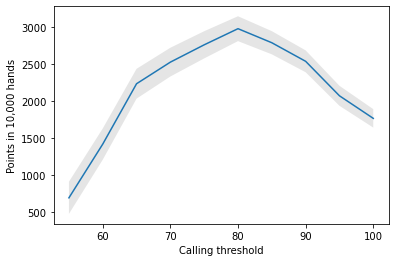

In [87]:
import matplotlib.pyplot as plt
plt.plot(thresholds, performance)
plt.fill_between(thresholds, performance+np.sqrt(1e4)*error, performance-np.sqrt(1e4)*error, alpha=0.2, facecolor='gray')
plt.xlabel('Calling threshold')
plt.ylabel('Points in 10,000 hands')
plt.show()

Preliminarily, looks like 70ish is best. Let's look run a wide search again, but with finer specificity in the thresholds

In [88]:
thresholds2 = range(55, 101, 1)
performance2, error2 = search_performance(thresholds2, prnt=False) # last time took about 3-4 minutes, should make this take about 15-20

Evaluating performance for threshold 55...
Evaluating performance for threshold 56...
Evaluating performance for threshold 57...
Evaluating performance for threshold 58...
Evaluating performance for threshold 59...
Evaluating performance for threshold 60...
Evaluating performance for threshold 61...
Evaluating performance for threshold 62...
Evaluating performance for threshold 63...
Evaluating performance for threshold 64...
Evaluating performance for threshold 65...
Evaluating performance for threshold 66...
Evaluating performance for threshold 67...
Evaluating performance for threshold 68...
Evaluating performance for threshold 69...
Evaluating performance for threshold 70...
Evaluating performance for threshold 71...
Evaluating performance for threshold 72...
Evaluating performance for threshold 73...
Evaluating performance for threshold 74...
Evaluating performance for threshold 75...
Evaluating performance for threshold 76...
Evaluating performance for threshold 77...
Evaluating 

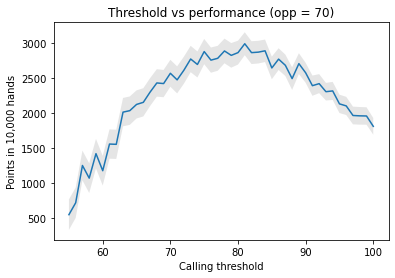

In [89]:
plt.plot(thresholds2, performance2)
plt.fill_between(thresholds2, performance2+np.sqrt(1e4)*error2, performance2-np.sqrt(1e4)*error2, alpha=0.2, facecolor='gray')
plt.xlabel('Calling threshold')
plt.ylabel('Points in 10,000 hands')
plt.title('Threshold vs performance (opp = 70)')

if 'figs' not in os.listdir():
    os.mkdir('figs')
plt.savefig('figs/threshold_vs_performance_shallow.png')

plt.show()

# Make this plot for three different opponent sets

In [90]:
thresholds = range(60, 101, 1)
opp_thresholds = [65, 80, 100]
performance3 = {op_thresh : search_performance(thresholds, opp_thresh=op_thresh, prnt=False) for op_thresh in opp_thresholds}
# should take like 45 minutes


Done!



Done!



Done!


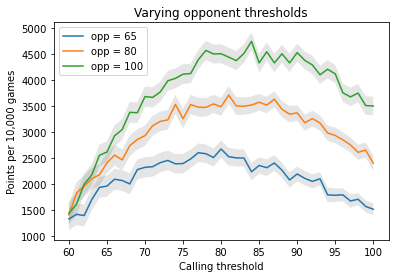

In [91]:
for op_thresh in opp_thresholds:
    plt.plot(thresholds, performance3[op_thresh][0], label='opp = ' + str(op_thresh))
    plt.fill_between(thresholds, performance3[op_thresh][0]+np.sqrt(1e4)*performance3[op_thresh][1],
                                 performance3[op_thresh][0]-np.sqrt(1e4)*performance3[op_thresh][1],
                                 alpha=0.2, facecolor='gray')

plt.xlabel('Calling threshold')
plt.ylabel('Points per 10,000 games')
plt.legend()
plt.title('Varying opponent thresholds')

plt.savefig('figs/threshold_vs_performance_varyopp.png')

plt.show()

# Make the plot, but with more trials

In [8]:
multiprocessing.cpu_count()

12

In [34]:
#search_performance_parallel(args=(thresholds[i], i, n_epochs, n_hands, None, folder, None, os.getcwd())))
search_performance_parallel(70, 0, 1, 100, None, 'thresh70', None, 'thresholds')

Threshold = 70:   0%|          | 0/1 [00:00<?, ?it/s]

Done!


In [51]:
%%time
# goal is to do a million each, so 10^2 epochs x 10^4 hands per epoch seems fine
thresholds=range(70,92)
parallel_search_wrapper(thresholds=thresholds, n_epochs=1e2, n_hands=1e4, ROOT_DIR='thresholds/')

Threshold = 75:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 72:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 71:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 79:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 80:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 81:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 82:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 83:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 84:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 85:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 86:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 87:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 88:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 89:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 90:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 91:   0%|          | 0/100 [00:00<?, ?it/s]

Done!
This took 13940.68 seconds
This took 232.34 minutes
This took 3.87 hours
CPU times: user 25 s, sys: 24.9 s, total: 49.9 s
Wall time: 3h 52min 20s


# Metric should be $\Delta$ points, not total points

If the opponents call it always, you get 0 called points, but you might euchre them a lot, meaning you get more points than them

### Making the original graph (threshold vs performance, 55-100, shallow), but with this new understanding

In [ ]:
%%time
parallel_search_wrapper(thresholds=range(55,101), n_epochs=10, n_hands=1000, ROOT_DIR='thresholds')

Threshold = 56:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 57:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 61:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 58:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 62:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 59:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 55:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 60:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 63:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 64:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 65:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 66:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 67:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 68:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 69:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 71:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 72:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 75:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/10 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/10 [00:00<?, ?it/s]

Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [4]:
%%time
get_performance(ROOT_DIR=os.path.join(os.getcwd(), 'thresholds'), use_mp=True, amount_tqdm=2)

         Threshold 88...Threshold 75...Threshold 72...Threshold 86...Threshold 80...Threshold 81...Threshold 74...Threshold 73...









  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 Threshold 87...  
Threshold 89... 
 Threshold 94...Threshold 60...

Threshold 58...
 Threshold 67...
 Threshold 93... 
Threshold 69...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  Threshold 68...Threshold 56... 

Threshold 57...
  Threshold 59...Threshold 92...

 Threshold 66...
 Threshold 100...
 Threshold 61...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 Threshold 95...
  Threshold 76...Threshold 78...

 Threshold 82... 
Threshold 85...
 Threshold 71...
 Threshold 70...
 Threshold 84...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 Threshold 83...
 Threshold 77...
 Threshold 79... 
Threshold 64... 
Threshold 90...
  Threshold 97...Threshold 63...

 Threshold 55...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 Threshold 99...
  Threshold 98...Threshold 62...

  Threshold 96... Threshold 91...
Threshold 65...



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Done!
CPU times: user 1.33 s, sys: 1.08 s, total: 2.42 s
Wall time: 8.63 s


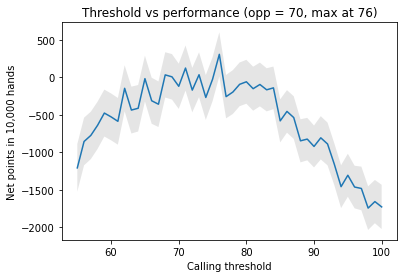

In [6]:
df = pd.read_csv('thresholds/performance.csv').sort_values('Threshold')
points, error = df['TotalSum']-df['OppSum'], np.sqrt(df['TotalStd']**2 + df['OppStd']**2)
plt.plot(df['Threshold'], points)
plt.fill_between(df['Threshold'], points+error, points-error, alpha=0.2, facecolor='gray')
plt.xlabel('Calling threshold')
plt.ylabel('Net points in 10,000 hands')
mx_thresh = df[(df['TotalSum']-df['OppSum'])==(df['TotalSum']-df['OppSum']).max()]['Threshold']
plt.title('Threshold vs performance (opp = 70, max at %i)' %mx_thresh)

if 'figs' not in os.listdir():
    os.mkdir('figs')
plt.savefig('figs/threshold_vs_performance_shallow.png')

plt.show()

### Making the second graph, thresh vs performance for varying opp thresholds

In [14]:
for opp_thresh in [60, 80, 100]:
    print()
    print('OPP THRESHOLD:', opp_thresh)
    parallel_search_wrapper(thresholds=range(65,106), n_epochs=100, n_hands=1000, ROOT_DIR='thresholds', opp_thresh=opp_thresh)
    print('Getting performance...')
    get_performance(ROOT_DIR=os.path.join(os.getcwd(), 'thresholds'), use_mp=True, amount_tqdm=0,\
                    outfile='performance_100k_oppthresh'+str(opp_thresh)+'.csv')


OPP THRESHOLD: 60
        

Threshold = 71:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 65:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 66:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 67:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 68:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 69:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 72:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 75:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 79:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 80:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 81:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 82:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 83:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 84:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 85:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 86:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 87:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 88:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 89:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 90:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 91:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 92:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 93:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 94:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 95:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 96:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 97:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 98:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 99:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 100:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 101:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 102:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 103:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 104:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 105:   0%|          | 0/100 [00:00<?, ?it/s]

Done!
This took 4347.38 seconds
This took 72.46 minutes
Getting performance...
                                                   Done!

OPP THRESHOLD: 80
        

Threshold = 66:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 65:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 69:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 67:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 68:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 71:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 72:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 75:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 79:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 80:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 81:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 82:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 83:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 84:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 85:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 86:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 87:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 88:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 89:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 90:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 91:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 92:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 93:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 94:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 95:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 96:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 97:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 98:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 99:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 100:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 101:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 102:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 103:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 104:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 105:   0%|          | 0/100 [00:00<?, ?it/s]

Done!
This took 2850.85 seconds
This took 47.51 minutes
Getting performance...
                                                   Done!

OPP THRESHOLD: 100
        

Threshold = 65:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 71:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 66:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 67:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 68:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 69:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 72:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 75:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 79:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 80:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 81:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 82:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 83:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 84:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 85:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 86:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 87:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 88:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 89:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 90:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 91:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 92:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 93:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 94:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 95:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 96:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 97:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 98:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 99:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 100:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 101:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 102:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 103:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 104:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 105:   0%|          | 0/100 [00:00<?, ?it/s]

Done!
This took 2880.95 seconds
This took 48.02 minutes
Getting performance...
                                                   Done!


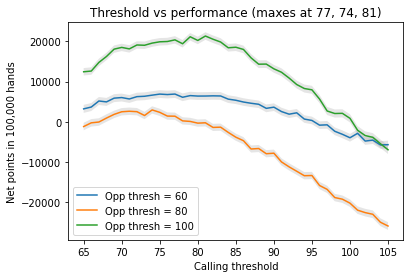

In [16]:
maxes = []
for opp_thresh in [60, 80, 100]:
    df = pd.read_csv('thresholds/performance_100k_oppthresh' + str(opp_thresh)+'.csv').sort_values('Threshold')
    df = df[df['TotalHands'] > 10000]
    points, error = df['TotalSum']-df['OppSum'], np.sqrt(df['TotalStd']**2 + df['OppStd']**2)
    plt.plot(df['Threshold'], points, label='Opp thresh = ' + str(opp_thresh))
    plt.fill_between(df['Threshold'], points+error, points-error, alpha=0.2, facecolor='gray')
    maxes.append(df[(df['TotalSum']-df['OppSum'])==(df['TotalSum']-df['OppSum']).max()]['Threshold'])
plt.xlabel('Calling threshold')
plt.ylabel('Net points in 100,000 hands')
plt.title('Threshold vs performance (maxes at %i, %i, %i)' %(maxes[0], maxes[1], maxes[2]))

plt.legend()
if 'figs' not in os.listdir():
    os.mkdir('figs')
plt.savefig('figs/threshold_vs_performance_varyopp.png')

plt.show()

In [6]:
board = Board()
for i in range(100):
    board.play_hand()
board.writeout(folder='testing', keep_results=False, ROOT_DIR='thresholds')

### Making the 3rd plot, thresh vs performance deep

In [18]:
%%time
parallel_search_wrapper(thresholds=range(70,94), n_epochs=100, n_hands=10000, ROOT_DIR='thresholds', opp_thresh=70)

Threshold = 72:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 75:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 74:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 71:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 73:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 70:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 76:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 77:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 78:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 79:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 80:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 81:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 82:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 83:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 84:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 85:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 86:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 87:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 88:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 89:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 90:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 91:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 92:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold = 93:   0%|          | 0/100 [00:00<?, ?it/s]

Done!
This took 13830.99 seconds
This took 230.52 minutes
This took 3.84 hours
CPU times: user 12.6 s, sys: 10.2 s, total: 22.8 s
Wall time: 3h 50min 30s


In [20]:
%%time
get_performance(ROOT_DIR=os.path.join(os.getcwd(), 'thresholds'), use_mp=True, amount_tqdm=1)

Writing to file: /Users/taylora/Documents/Personal/RL/euchre/thresholds/performance.csv
         Threshold 88...Threshold 72...Threshold 86...Threshold 74...Threshold 75...Threshold 81...Threshold 80...Threshold 73...









  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 Threshold 87...
 Threshold 89...
 Threshold 93...
 Threshold 92...
 Threshold 78...
 Threshold 76...
 Threshold 82...
 Threshold 85...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

 Threshold 71...
 Threshold 70...
 Threshold 84...
 Threshold 83...
 Threshold 77...
 Threshold 79...
 Threshold 90...
 Threshold 91...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Done!
CPU times: user 15.8 s, sys: 13.1 s, total: 28.9 s
Wall time: 6min 57s


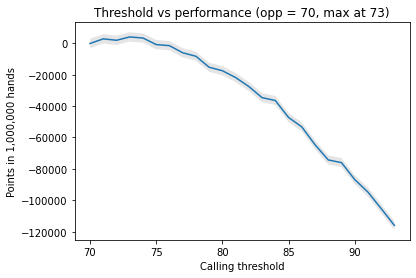

In [29]:
df = pd.read_csv('thresholds/performance_1M.csv').sort_values('Threshold')
df = df[df['TotalHands']==int(1e6)]
points, error = df['TotalSum']-df['OppSum'], np.sqrt(df['TotalStd']**2 + df['OppStd']**2)
plt.plot(df['Threshold'], points)
plt.fill_between(df['Threshold'], points+error, points-error, alpha=0.2, facecolor='gray')
plt.xlabel('Calling threshold')
plt.ylabel('Points in 1,000,000 hands')
mx_thresh = df[(df['TotalSum']-df['OppSum'])==(df['TotalSum']-df['OppSum']).max()]['Threshold']
plt.title('Threshold vs performance (opp = 70, max at %i)' %mx_thresh)

if 'figs' not in os.listdir():
    os.mkdir('figs')
plt.savefig('figs/threshold_vs_performance_deep.png')

plt.show()

# Using data made on HPC

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

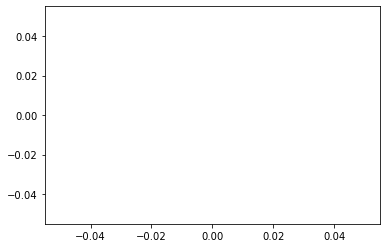

In [25]:
df = pd.read_csv('thresholds/performance_10M.csv').sort_values('Threshold')
df = df[df['TotalHands']==int(1e6)]
points, error = df['TotalSum']-df['OppSum'], np.sqrt(df['TotalStd']**2 + df['OppStd']**2)
plt.plot(df['Threshold'], points)
plt.fill_between(df['Threshold'], points+error, points-error, alpha=0.2, facecolor='gray')
plt.xlabel('Calling threshold')
plt.ylabel('Points in 10 million hands')
mx_thresh = df[(df['TotalSum']-df['OppSum'])==(df['TotalSum']-df['OppSum']).max()]['Threshold']
plt.title('Threshold vs performance (opp = 70, max at %i)' %mx_thresh)

if 'figs' not in os.listdir():
    os.mkdir('figs')
plt.savefig('figs/threshold_vs_performance_superdeep.png')

plt.show()